---
## Assumptions and rules
---

Use a simple, consistent backtest setup:
- Trade at **next day close** (i.e., use yesterday’s signal as today’s position)
- Transaction costs is 0.05% 
- Trading on portfolio of $1 million
- Ignore slippage 
- Long/cash only for Part A
-

### What “backtest” means here
A backtest simulates how your portfolio would have performed historically if you had followed your trading rules mechanically.


In [1]:
# Import your functions

---
# Part A: Core Task — Implement One Momentum Strategy
---




---
## Step 1: Libraries 
---

In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import quantstats as qs
import warnings

ModuleNotFoundError: No module named 'yfinance'

---
## Step 2: Load price data
---


In [ ]:
# Prepare Apple data into a dataframe
def download_stock_data(ticker, start_date):
    data = yf.download(
        ticker,
        start=start_date,
        auto_adjust=True, #prices adjusted for dividends and splits
        progress=False
    )
    return data['Close'] 

# Download Apple data
prices = download_stock_data("AAPL", "2015-01-01") #close prices series indexed by date


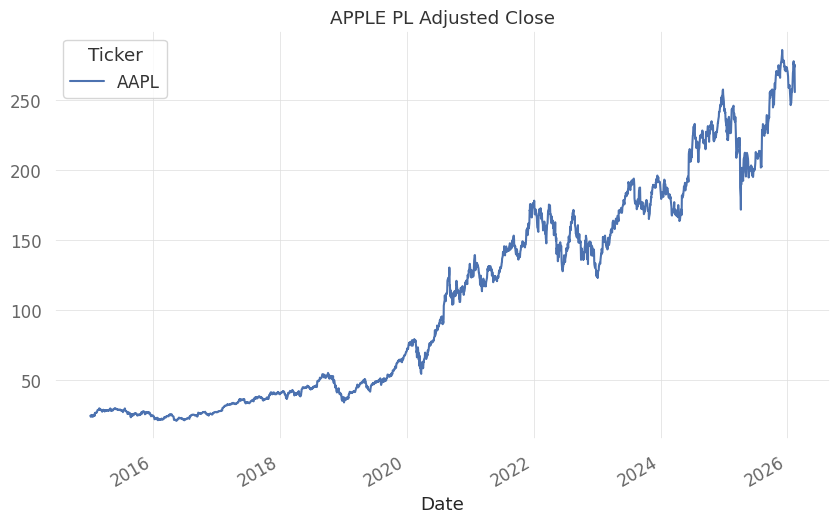

In [ ]:
# Display the visualisation of the data
prices.plot(title="APPLE PL Adjusted Close")
plt.show()

---
## Step 2: Karthik - Backtest framework
---

You will generate a `signal`:
- `1` = long
- `0` = cash

The backtest uses `position = signal.shift(1)` to avoid look-ahead bias.


In [ ]:

from __future__ import annotations

from dataclasses import dataclass #create dataclass (container object) to store results
from typing import Callable, Dict, Optional, Tuple, Union  #create typing hints


StrategyFn = Callable[[pd.Series, pd.DataFrame, dict], pd.Series]
#define a strategy function that takes three inputs: prices, data (e.g. volume, open, high etc.), dictionary of parameters to adjust settings
# function gives one output, a position series

@dataclass
class BacktestResult: #creates an object to store the necessary data for each backtest
    prices: pd.Series
    returns: pd.Series
    position: pd.Series #long or cash position (1 or 0)
    trades: pd.Series #volume of trades
    equity_strategy: pd.Series #results of the trading strategy
    equity_buyhold: pd.Series #benchmark results of buying and holding from day 1
    drawdown: pd.Series #peak to trough percentage
    results: Dict[str, Union[str, float, int]] #stores results in a dictionary as it holds multiple different data types

#download stock price data below with a function
def load_prices(
    ticker: str, #stock symbol as a string
    start: str, #starting date
    end: Optional[str] = None, # ending date or to present
    auto_adjust: bool = True  #auto adjust for stock splits
) -> Tuple[pd.Series, pd.DataFrame]: #returns two outputs
    data = yf.download(
        ticker,
        start=start,
        end=end,
        auto_adjust=auto_adjust,
        progress=False
    )
    if data.empty:
        raise ValueError(f"No data returned for {ticker}") #if error in data, stop code 

    close = data["Close"] #extracts close column
    if isinstance(close, pd.DataFrame):
        close = close.iloc[:, 0] #extracts first column if close is a dataframe not a series

    prices = close.dropna().astype(float) #dropna removes missing values, ensures float structure
    data = data.loc[prices.index] #remove dates if prices are missing
    return prices, data #returns close prices as a series and full data in a df


def run_backtest( #backtesting simulation
    ticker: str,
    start: str,
    strategy_fn: StrategyFn, #input the type of strategy used
    strategy_params: Optional[dict] = None, #strategy can use different parameters (optional)
    end: Optional[str] = None,
    initial_capital: float = 1_000_000.0, #starting capital
    fee_rate_per_trade: float = 0.0005, #transaction dee of 0.05%
    shift_signals_by: int = 1, #prevents look-ahead bias by shifting signals forward 1 day, only trading at next day close
    auto_adjust: bool = True,
) -> BacktestResult:
    params = strategy_params or {} #if no additional parameters, replace it with an empty dictionary to prevent errors

    prices, data = load_prices(ticker, start=start, end=end, auto_adjust=auto_adjust) #calls function to extract all market data

    raw_position = strategy_fn(prices, data, params) #runs trading strrategy and returns position (1 or 0)
    raw_position = raw_position.reindex(prices.index).fillna(0.0) #realign position with dates and if some dates are misisng, fill them with 0 (cash), prevents code from crashing
    raw_position = pd.to_numeric(raw_position, errors="coerce").fillna(0.0) #converts to numbers, missing data converted to 0, prevents errors

    position = raw_position.shift(shift_signals_by).fillna(0.0) #shift signal forward 1 day

    returns = prices.pct_change().fillna(0.0) #percentage change between days
    trades = position.diff().abs().fillna(0.0) # number of trades (absolute value so buy and sell both increase volume)

    strategy_returns_gross = position * returns #caluclate returns before fees
    strategy_returns_net = strategy_returns_gross - trades * fee_rate_per_trade #calculates net returns

    equity_strategy = initial_capital * (1.0 + strategy_returns_net).cumprod() #calculating portfolio value cumulatively over time
    equity_buyhold = initial_capital * (prices / prices.iloc[0]) #calculates return of a benchmark buy and hold strategy

    running_max = equity_strategy.cummax() #calculates the cumulative maximum for each day
    drawdown = equity_strategy / running_max - 1.0 #calculate drawdown
    max_drawdown = float(drawdown.min()) #extracts worst drawdown and converts to float

    final_value = float(equity_strategy.iloc[-1]) #final portfolio value
    profit = final_value - initial_capital
    profit_pct = final_value / initial_capital - 1.0

    results = { #construct a backtest result object which encapsulates all data
        "ticker": ticker,
        "start": start,
        "end": str(equity_strategy.index[-1].date()), #writes the end date in a string
        "initial_capital": float(initial_capital),
        "ending_value_strategy": float(equity_strategy.iloc[-1]), #ending portfolio value of strategy
        "ending_value_buyhold": float(equity_buyhold.iloc[-1]), #ending benchmark portfolio value
        "profit_strategy": float(profit),
        "profit_pct_strategy": float(profit_pct),
        "max_drawdown_strategy": float(max_drawdown),
        "trades": float(trades.sum()),
        "fee_rate_per_trade": float(fee_rate_per_trade),
        "strategy_name": getattr(strategy_fn, "__name__", "strategy_fn"),
        "strategy_params": dict(params), #stores the parameters used in the backtest
    }

    return BacktestResult(
        prices=prices,
        returns=returns,
        position=position,
        trades=trades,
        equity_strategy=equity_strategy,
        equity_buyhold=equity_buyhold,
        drawdown=drawdown,
        results=results,
    )
    #returns all results 

---
## Step 3: Implement 3 Strategies
---




---
### Arin: ROC Threshold
---

**Rule:** Buy if the price increased by more than a threshold over the last `roc_n` days.


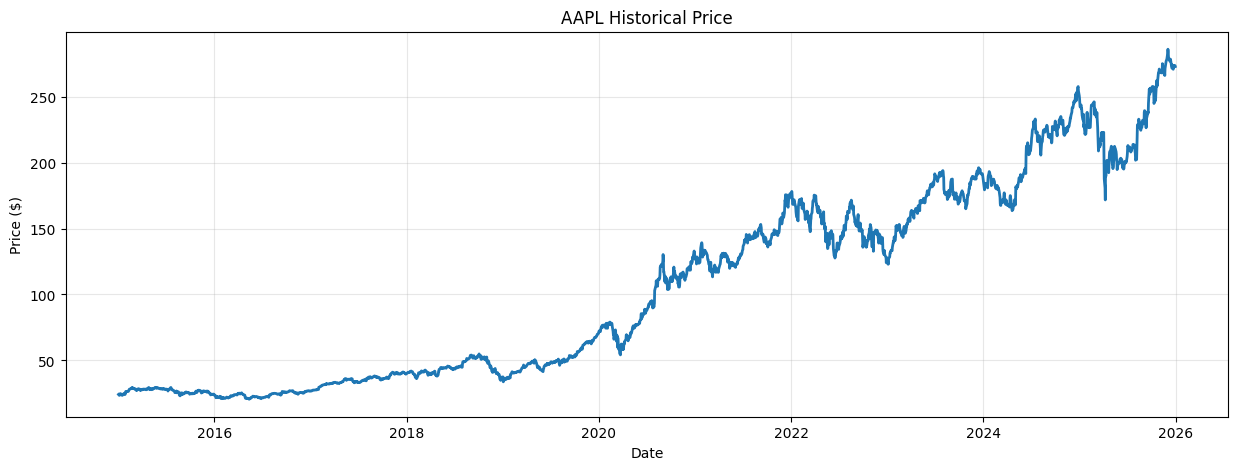


--------------------------------------------------
BACKTEST RESULTS
--------------------------------------------------
Strategy Return: 121.58%
Buy & Hold Return: 1026.68%
Number of Trades: 366
Max Drawdown: -31.78%
--------------------------------------------------


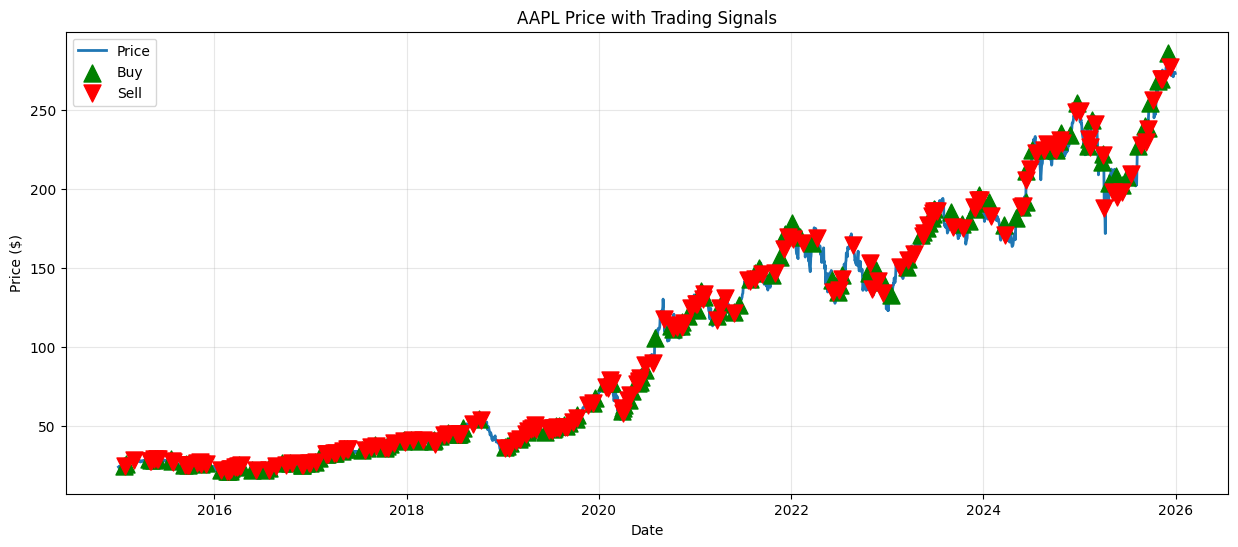

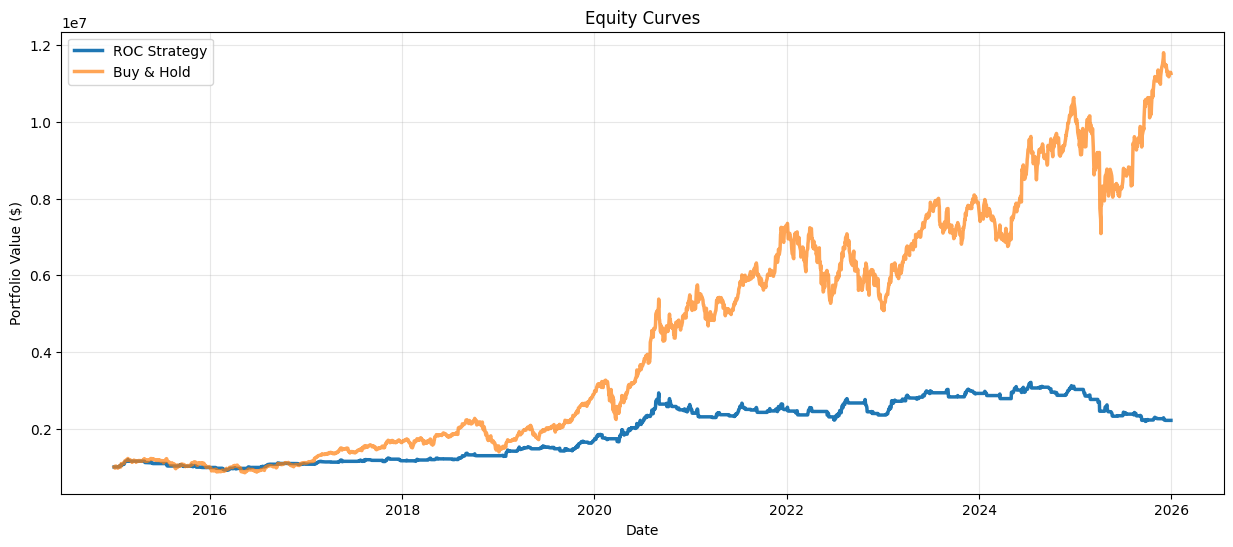

In [1]:

import yfinance as yf 
import pandas as pd
import matplotlib.pyplot as plt
from backtest_function import run_backtest
# print quick price chart for appl
initial_data = yf.download('AAPL', start='2015-01-01', end='2025-12-31', progress=False)
plt.figure(figsize=(15, 5))
plt.plot(initial_data.index, initial_data['Close'], linewidth=2)
plt.title('AAPL Historical Price')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.grid(alpha=0.3)
plt.show()
#create roc strategy function
def roc_strategy(prices: pd.Series, data: pd.DataFrame, params: dict) -> pd.Series:
    "Generate ROC signals: 1 = long, 0 = cash"
    roc_n = params.get('roc_n', 10) #10 day period - play around with this to see how it affects performance
    roc_threshold = params.get('roc_threshold', 3.0) #3% threshold, play around
    
    roc = ((prices - prices.shift(roc_n)) / prices.shift(roc_n)) * 100
    signal = (roc > roc_threshold).astype(int) # create series of true/false based on ROC to threshold, true =1,false = 0
    return signal

# run backtest
params = {'roc_n': 10, 'roc_threshold': 3.0} # dictionary of parameters to pass to strategy

trade_result = run_backtest(
    ticker='AAPL',
    start='2015-01-01', # can change these as well
    end='2025-12-31',
    strategy_fn=roc_strategy, #use strat function just created to decide when to be long or in cash
    strategy_params=params
)

# deliverables
total_return = (trade_result.results['ending_value_strategy'] / trade_result.results['initial_capital'] - 1) * 100
buyhold_return = (trade_result.results['ending_value_buyhold'] / trade_result.results['initial_capital'] - 1) * 100
num_trades = int(trade_result.results['trades'])
#just fetching the relevant metrics from the backtest results to print out in a nice format

print("\n" + "-"*50)
print("BACKTEST RESULTS")
print("-"*50)
print(f"Strategy Return: {total_return:.2f}%")
print(f"Buy & Hold Return: {buyhold_return:.2f}%")
print(f"Number of Trades: {num_trades}")
print(f"Max Drawdown: {trade_result.results['max_drawdown_strategy']*100:.2f}%")
print("-"*50)

# Price Signals Plot
buy = trade_result.position.diff() == 1
sell = trade_result.position.diff() == -1

plt.figure(figsize=(15, 6))
plt.plot(trade_result.prices.index, trade_result.prices, label='Price', linewidth=2)
plt.scatter(trade_result.prices[buy].index, trade_result.prices[buy], 
           marker='^', color='green', s=150, label='Buy', zorder=5)
plt.scatter(trade_result.prices[sell].index, trade_result.prices[sell],
           marker='v', color='red', s=150, label='Sell', zorder=5)
#formatted more
plt.title('AAPL Price with Trading Signals')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# equity chart
plt.figure(figsize=(15, 6))
plt.plot(trade_result.equity_strategy.index, trade_result.equity_strategy, 
         label='ROC Strategy', linewidth=2.5)
plt.plot(trade_result.equity_buyhold.index, trade_result.equity_buyhold,
         label='Buy & Hold', linewidth=2.5, alpha=0.7)
plt.title('Equity Curves')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()



 ## Conclusions and Insights

The Rate of Change (ROC) indicator measures the percentage price change over the past 10 days, capturing short-term momentum by comparing today's price to the price 10 trading days ago. The strategy enters a long position when ROC exceeds 3%, signaling strong upward momentum, and exits to cash when ROC falls below 3%, indicating weakening or negative momentum. This strategy exploits investor underreaction and herding behavior when prices begin rising, information diffuses slowly through the market, and momentum builds as more investors observe the trend and pile in, creating self-reinforcing continuation patterns.

The strategy however has several limitations: it assumes momentum persists long enough to profit but is vulnerable to sharp reversals during trend breakdowns. We ignore transaction costs and slippage, which would reduce real-world returns with frequent trading. The 10-day lookback and 3% threshold are arbitrary parameters not optimized for different market conditions. This long-only approach cannot profit from downward momentum i.e short selling, and the backtest suffers from survivorship bias by testing only on one stock, AAPL, a successful stock. As such, the strategy looks comparatively weaker compared to the substantial returns gained from a simple buy and hold over 10 years.

---
### Adrian: Moving Average Crossover
---

**Rule:** Buy when a fast moving average is above a slow moving average.


In [ ]:
# Develop the Moving Average Crossover indicator

---
### Piraveen: MACD Signal
---

**Rule:** Buy when MACD is above its signal line.
- `MACD = EMA(12) - EMA(26)`
- `Signal line = EMA(9) of MACD`


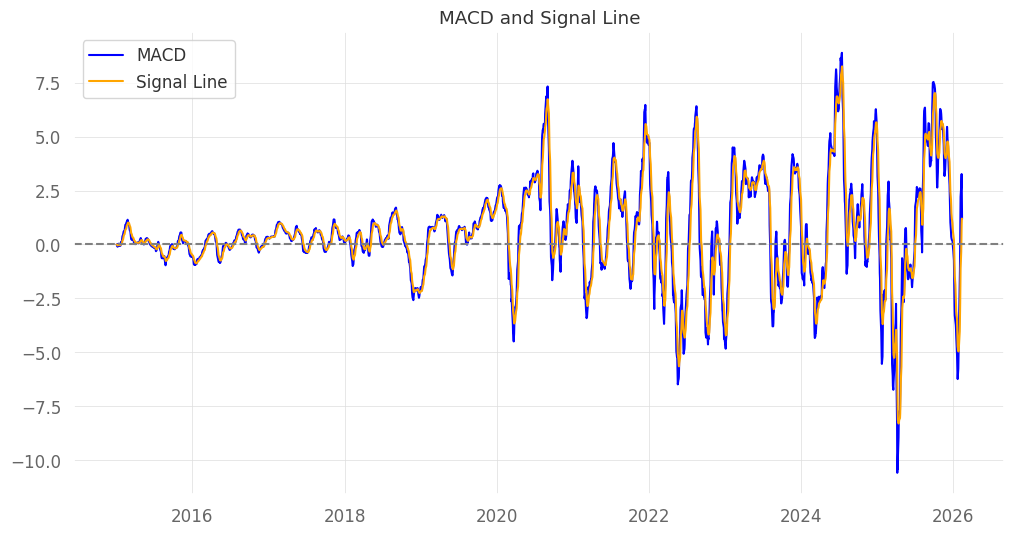

Bullish signals: Ticker
AAPL    100
dtype: int64
Bearish signals: Ticker
AAPL    101
dtype: int64


In [ ]:
#Compute MACD 

def calculate_macd(prices, fast_span=12, slow_span=26, signal_span=9):
    # Calculate MACD components
    ema_fast = prices.ewm(span=fast_span, adjust=False).mean()
    ema_slow = prices.ewm(span=slow_span, adjust=False).mean()
    macd_line = ema_fast - ema_slow

    # Smooth the MACD line to get the signal line and calculate the histogram
    signal_line = macd_line.ewm(span=signal_span, adjust=False).mean()
    histogram = macd_line - signal_line

    return macd_line, signal_line, histogram #returns one object as a tuple (ordered container of three objects) of three series: macd_line, signal_line, histogram

# Calculate MACD
macd, signal, histogram = calculate_macd(prices) # tuple unpacking, internally macd = calculate_macd(prices)[0], signal = calculate_macd(prices)[1], histogram = calculate_macd(prices)[2]

# Plot MACD and Signal line
plt.figure(figsize=(12, 6))
plt.plot(macd, label="MACD", color="blue")
plt.plot(signal, label="Signal Line", color="orange")

plt.axhline(0, color="gray", linestyle="--") # Add a horizontal line at y=0 for reference
plt.title("MACD and Signal Line")
plt.legend()
plt.show()

# Generate trading signals by shifting yesterday's MACD and Signal values to indicate crossovers
bullish_signals = ((macd > signal) & (macd.shift(1) <= signal.shift(1))).sum() # Count the number of times the MACD line crosses above the Signal line (bullish crossover) -> crossover due to macd.shift(1) and signal.shift(1) are used to compare the current values of macd and signal with their previous values to identify crossovers.
bearish_signals = ((macd < signal) & (macd.shift(1) >= signal.shift(1))).sum() # Count the number of times the MACD line crosses below the Signal line (bearish crossover)

print(f"Bullish signals: {bullish_signals}")
print(f"Bearish signals: {bearish_signals}")

#### **MACD visually captures volatility + trend strength, not just direction.**

- The blue line is MACD, which measures short term momentum relative to the longer term trend.

- The orange line is the signal line, a smoothed version of MACD that represents the recent average level of momentum.

- The dashed zero line separates bullish and bearish momentum regimes.

**Explanation**

- When MACD crosses above the signal line, momentum is strengthening upward, generating a bullish signal.

- When MACD crosses below the signal line, momentum is weakening, generating a bearish signal.

- Larger swings indicate stronger momentum or higher volatility, which is especially visible after 2020.

**Why it is useful**

- It filters noisy price movements into momentum signals.

- It helps time entries and exits by identifying momentum accelerations and reversals rather than predicting price levels.

#### **Backtest framework over past 10 years vs Buy-Hold Strategy**

ticker: AAPL
start: 2015-01-01
end: 2026-02-13
initial_capital: 1000000.000000
ending_value_strategy: 7056875.906502
ending_value_buyhold: 10562918.231155
profit_strategy: 6056875.906502
profit_pct_strategy: 6.056876
max_drawdown_strategy: -0.270335
trades: 199.000000
fee_rate_per_trade: 0.000500
strategy_name: macd_strategy
strategy_params: {'fast_span': 12, 'slow_span': 26, 'signal_span': 9}


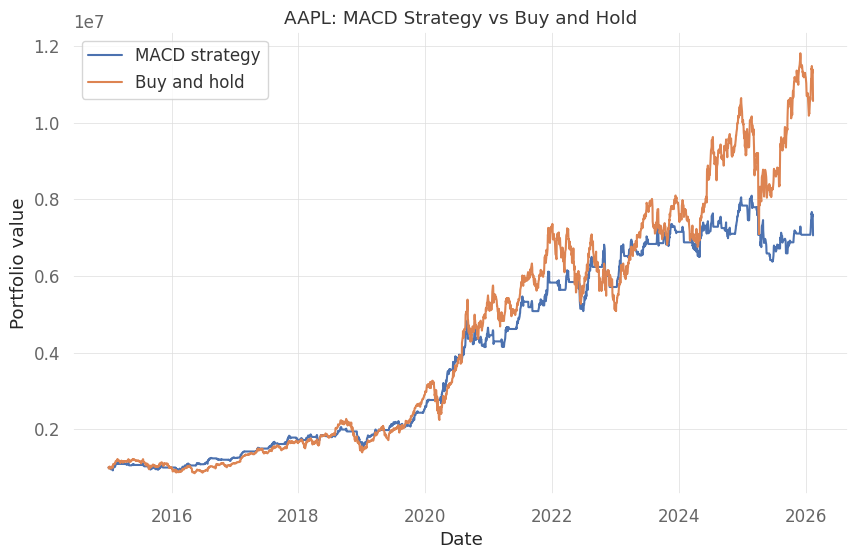

In [ ]:
# 1) Import your backtest engine (edit the module name to match your file)
from backtest_function import run_backtest
import pandas as pd
import matplotlib.pyplot as plt


# 2) Define your MACD strategy function (returns RAW position, no shifting here)
def macd_strategy(prices: pd.Series, data: pd.DataFrame, params: dict) -> pd.Series:
    fast = int(params.get("fast_span", 12))
    slow = int(params.get("slow_span", 26))
    sig  = int(params.get("signal_span", 9))

    ema_fast = prices.ewm(span=fast, adjust=False).mean()
    ema_slow = prices.ewm(span=slow, adjust=False).mean()

    macd = ema_fast - ema_slow
    signal = macd.ewm(span=sig, adjust=False).mean()

    # long-only: 1 when MACD > signal else 0
    return (macd > signal).astype(float)

# 3) Run the backtest
res = run_backtest(
    ticker="AAPL",
    start="2015-01-01",
    strategy_fn=macd_strategy,
    strategy_params={"fast_span": 12, "slow_span": 26, "signal_span": 9},
    initial_capital=1_000_000.0,
    fee_rate_per_trade=0.0005,
    shift_signals_by=1,   # avoids look-ahead bias
    auto_adjust=True
)

# 4) Print results
for k, v in res.results.items():
    if isinstance(v, float):
        print(f"{k}: {v:.6f}")
    else:
        print(f"{k}: {v}")

# 5) Plot equity curves
plt.figure()
plt.plot(res.equity_strategy, label="MACD strategy")
plt.plot(res.equity_buyhold, label="Buy and hold")
plt.title("AAPL: MACD Strategy vs Buy and Hold")
plt.xlabel("Date")
plt.ylabel("Portfolio value")
plt.legend()
plt.show()

#### **Reporting on graph**    

The orange line (buy and hold) grows faster in strong bull markets

The blue line (MACD) is smoother but **lags** badly when Apple trends strongly upward

Key visual insights:

*1) 2019–2021 bull market*

- Buy and hold explodes upward

- MACD repeatedly exits and re-enters

- This causes missed upside

*2)2022 market crash*

- Buy and hold falls hard

- MACD falls much less

*3) Post-2023 recovery*

- Buy and hold again dominates

- MACD stays cautious and under-participates

#### **COVID Period Analysis**

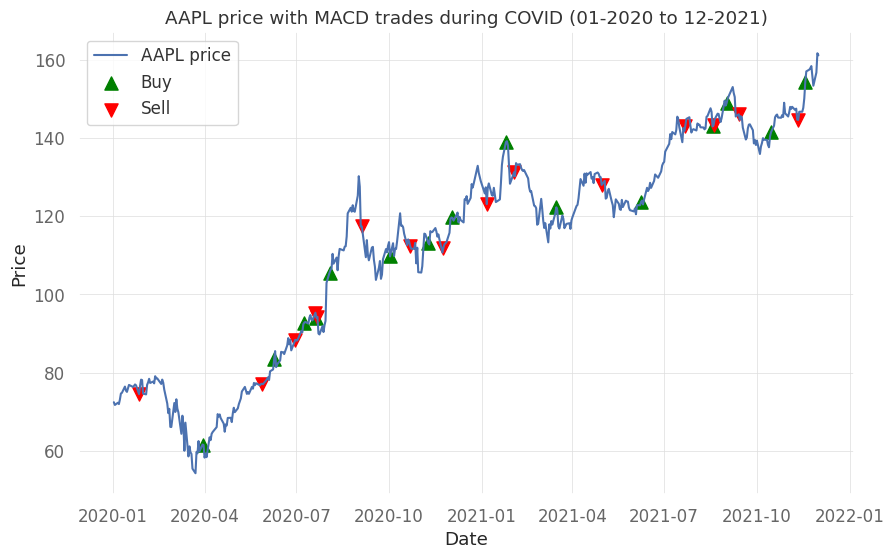

In [ ]:
# Analyze COVID period (2020-01-01 to 2021-12-01)
covid_start = "2020-01-01"
covid_end = "2021-12-01"

# Slice data for COVID period
px_covid = res.prices.loc[covid_start:covid_end]
pos_covid = res.position.reindex(px_covid.index).fillna(0).astype(int)

# Get entry and exit dates
changes = pos_covid.diff().fillna(0)
buy_dates = changes[changes == 1].index
sell_dates = changes[changes == -1].index

# Visualize
plt.figure()
plt.plot(px_covid.index, px_covid.values, label="AAPL price")
plt.scatter(buy_dates, px_covid.loc[buy_dates], marker="^", s=90, label="Buy", color='green')
plt.scatter(sell_dates, px_covid.loc[sell_dates], marker="v", s=90, label="Sell", color='red')
plt.title("AAPL price with MACD trades during COVID (01-2020 to 12-2021)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

#### **Final Quant (See File Named MACD Performance Report)**

In [ ]:
warnings.filterwarnings('ignore')

# Calculate returns
strategy_returns = res.equity_strategy.pct_change().dropna()
benchmark_returns = res.equity_buyhold.pct_change().dropna()

# Align dates
df = pd.concat([strategy_returns, benchmark_returns], axis=1).dropna()

# Generate HTML report
qs.reports.html(
    df.iloc[:, 0],
    benchmark=df.iloc[:, 1],
    output="performancereportMACD.html",
    title="Strategy vs Benchmark"
)

print("Done: performancereportMACD.html")

#### **Key takeaway from report**

The MACD strategy does not beat buy and hold AAPL in raw returns, but it materially improves risk-adjusted performance and downside control.

1) **Lower returns, lower risk**
 - Buy and hold AAPL delivers higher cumulative return and CAGR (about 1004% and 24.25%) than the MACD strategy (about 655% and 20.05%). However, the strategy earns these returns with much lower volatility and shallower drawdowns

2) **Superior risk adjusted metrics**
 - The strategy has a higher Sharpe and Sortino, higher Omega, higher Calmar, and better Ulcer and Serenity indices. This means more return per unit of risk and pain, even though absolute returns are lower

3) **Limitation: Opportunity cost in strong bull markets**
 - The strategy underperforms badly in sustained momentum regimes (2017, 2019, 2021, 2023, 2024) because it exits too early and stays out of the market roughly 45% of the time 

4) **Limitation: Lag and whipsaw from backward looking signals**
 - MACD reacts after trends change. In sideways or slowly trending regimes this causes false exits and re entries, lowering expected returns and profit ratio

